# Steam Games Success Prediction
## Predicting Game Success Based on Early Adopters

**Authors:** Ayan Mahmood, Nolan Hughes, Aryaman Srivastava
**Course:** CS513 - Data Mining  
**Dataset:** [Steam Games Dataset](https://www.kaggle.com/datasets/artermiloff/steam-games-dataset/data)

### Objective
Build classifier to predict whether a Steam game will be successful based on early adopter behavior and game characteristics.

### CS513 Methodologies Applied
- **KNN**
- **Naive Bayes**
- **CART**
- **C4.5, C5.0**
- **Random Forest**
- **ANN**
- **SVM**

## 1. Data Loading and Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Load the dataset
df = pd.read_csv('/Users/ayan/Documents/cs513/finalproject/data/games_march2025_full.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape[0]:,} games x {df.shape[1]} features")
print(f"\nGames with reviews: {(df['num_reviews_total'] > 0).sum():,}")


DATASET OVERVIEW

Shape: 94,948 games x 47 features

Games with reviews: 55,373


## 2. Exploratory Data Analysis


In [3]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("="*80)
print("DATA EXPLORATION")
print("="*80)
print(f"\nNumerical columns ({len(numerical_cols)})")
print(f"Categorical columns ({len(categorical_cols)})")

# Quick data quality check
print("\n" + "="*80)
print("DATA QUALITY & KEY STATISTICS")
print("="*80)

# Missing values (top 10 only)
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_table = pd.DataFrame({
    'Missing': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
}).sort_values('Percentage', ascending=False).head(10)

if len(missing_table) > 0:
    print("\nTop 10 columns with missing values:")
    display(missing_table)
    
# Key statistics
print(f"\nKey Metrics:")
print(f"  Games with reviews: {(df['num_reviews_total'] > 0).sum():,} ({(df['num_reviews_total'] > 0).mean()*100:.1f}%)")
print(f"  Average positive rating: {df['pct_pos_total'].mean():.1f}%")
print(f"  Median price: ${df['price'].median():.2f}")
print(f"  Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")


DATA EXPLORATION

Numerical columns (21)
Categorical columns (23)

DATA QUALITY & KEY STATISTICS

Top 10 columns with missing values:


,Missing,Percentage
score_rank,94909,99.958925
metacritic_url,91372,96.233728
reviews,84520,89.017146
notes,78296,82.461979
website,53754,56.614147
support_url,50763,53.464001
support_email,16100,16.956650
about_the_game,5449,5.738931
detailed_description,5426,5.714707
short_description,5349,5.633610



Key Metrics:
  Games with reviews: 55,373 (58.3%)
  Average positive rating: 44.6%
  Median price: $3.99
  Price range: $0.00 - $999.98


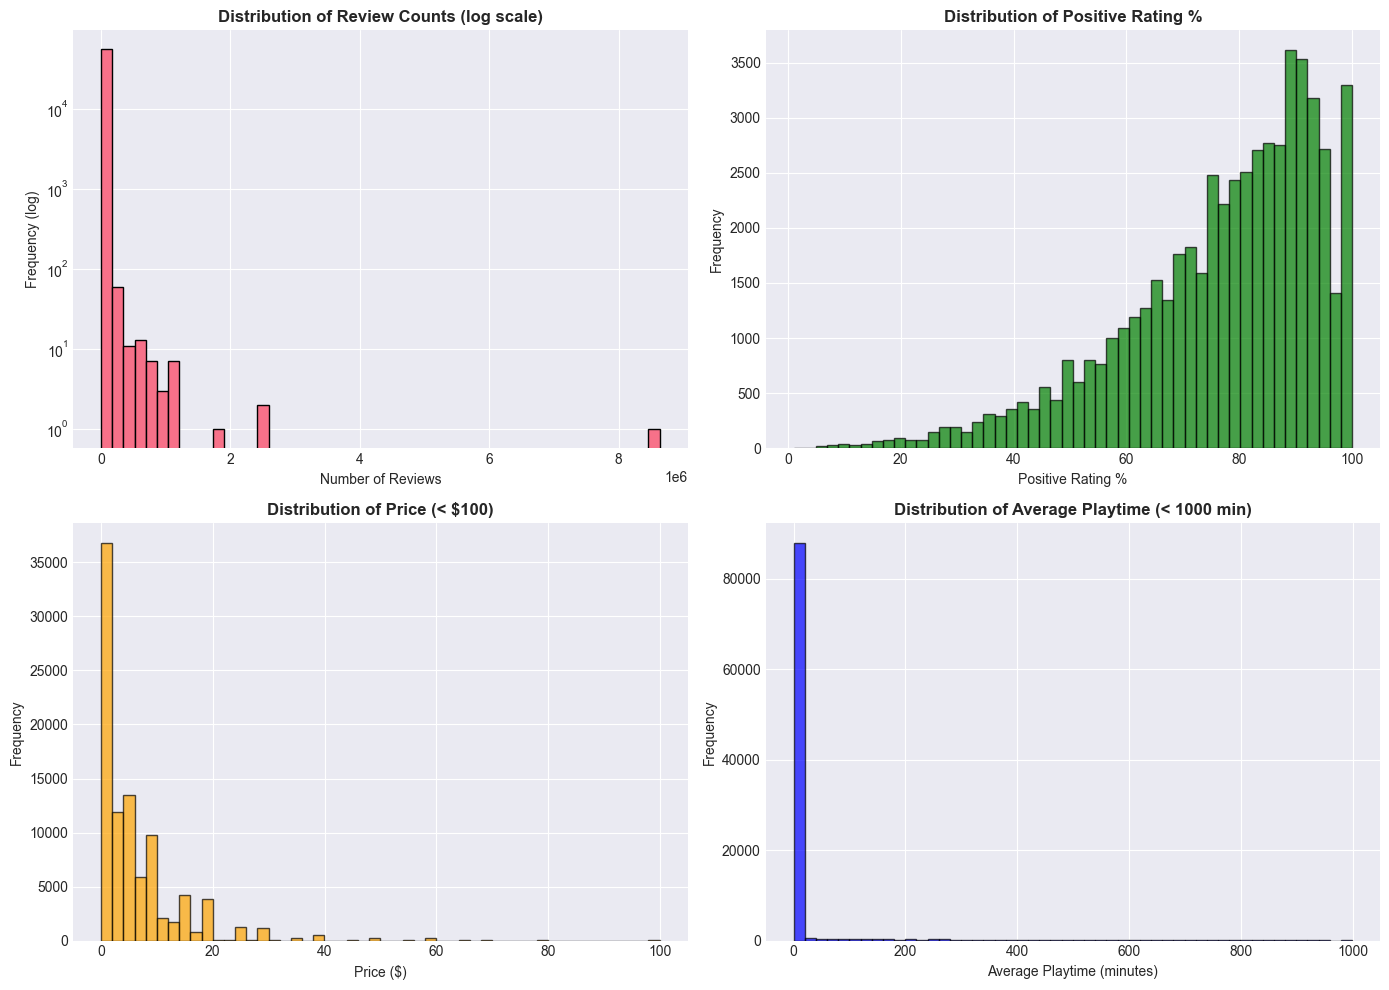

In [4]:
# Visualize key distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Reviews distribution (log scale)
axes[0, 0].hist(df[df['num_reviews_total'] > 0]['num_reviews_total'], bins=50, edgecolor='black', log=True)
axes[0, 0].set_title('Distribution of Review Counts (log scale)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Reviews')
axes[0, 0].set_ylabel('Frequency (log)')

# Rating distribution
axes[0, 1].hist(df[df['pct_pos_total'] > 0]['pct_pos_total'], bins=50, edgecolor='black', color='green', alpha=0.7)
axes[0, 1].set_title('Distribution of Positive Rating %', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Positive Rating %')
axes[0, 1].set_ylabel('Frequency')

# Price distribution
axes[1, 0].hist(df[df['price'] < 100]['price'], bins=50, edgecolor='black', color='orange', alpha=0.7)
axes[1, 0].set_title('Distribution of Price (< $100)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Frequency')

# Playtime distribution
axes[1, 1].hist(df[df['average_playtime_forever'] < 1000]['average_playtime_forever'], 
                bins=50, edgecolor='black', color='blue', alpha=0.7)
axes[1, 1].set_title('Distribution of Average Playtime (< 1000 min)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Playtime (minutes)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


CORRELATION ANALYSIS


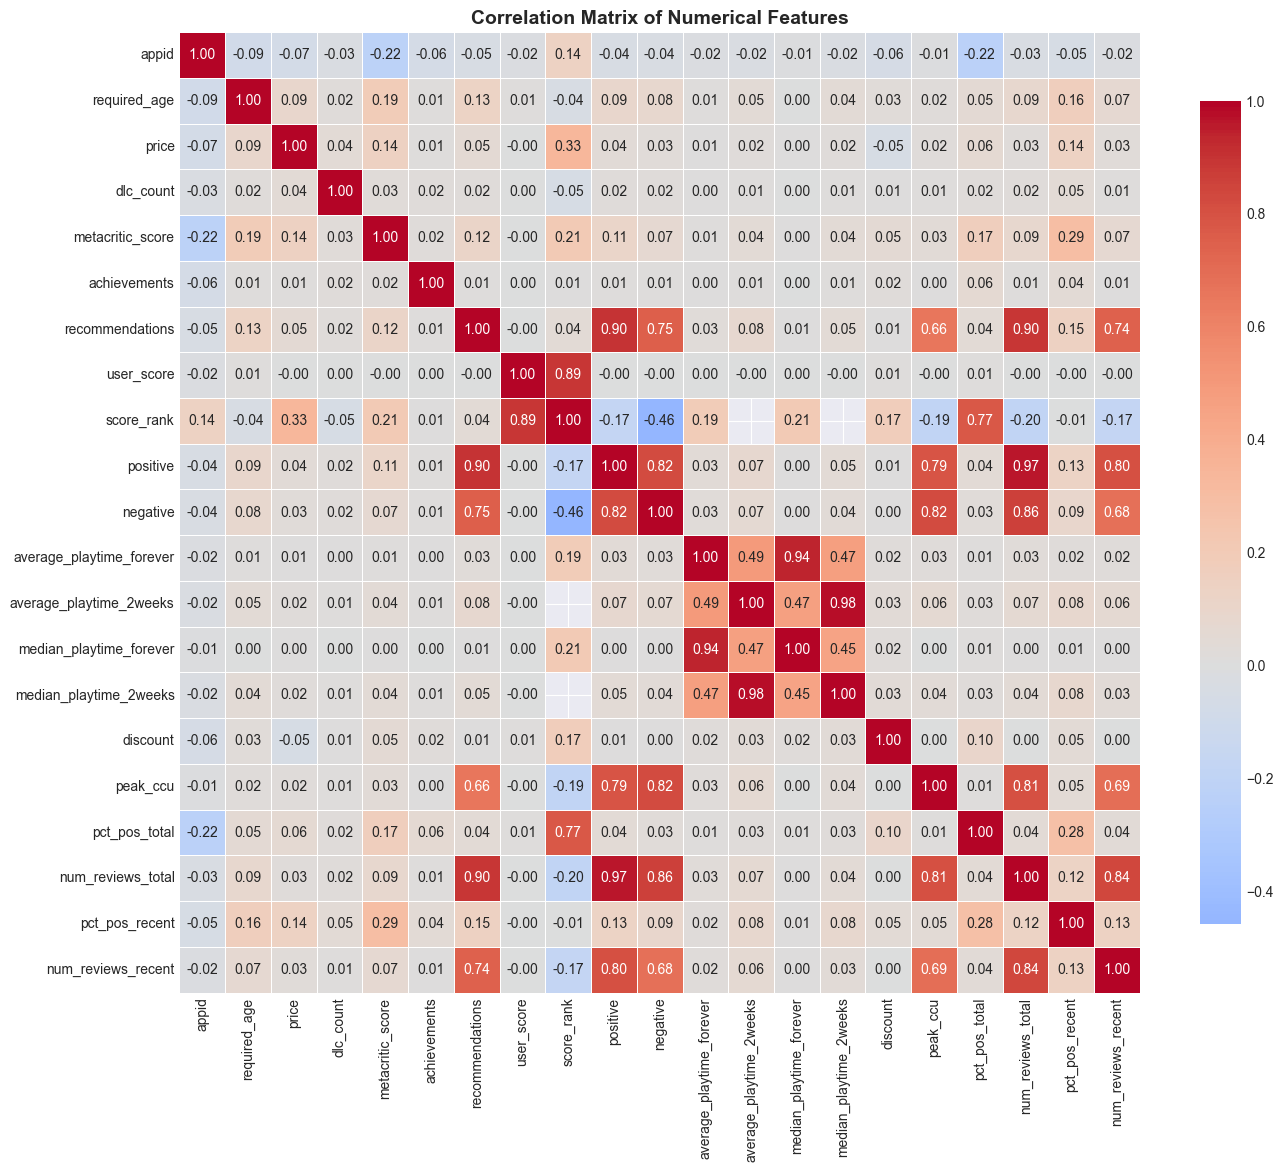


Highly Correlated Feature Pairs (|correlation| > 0.7):
  recommendations <-> positive: 0.899
  recommendations <-> negative: 0.753
  recommendations <-> num_reviews_total: 0.896
  recommendations <-> num_reviews_recent: 0.744
  user_score <-> score_rank: 0.891
  score_rank <-> pct_pos_total: 0.773
  positive <-> negative: 0.820
  positive <-> peak_ccu: 0.790
  positive <-> num_reviews_total: 0.965
  positive <-> num_reviews_recent: 0.805
  negative <-> peak_ccu: 0.822
  negative <-> num_reviews_total: 0.861
  average_playtime_forever <-> median_playtime_forever: 0.939
  average_playtime_2weeks <-> median_playtime_2weeks: 0.978
  peak_ccu <-> num_reviews_total: 0.806
  num_reviews_total <-> num_reviews_recent: 0.839


In [5]:
# Correlation analysis
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print highly correlated pairs
print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr:
    for feat1, feat2, corr in high_corr:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("  No highly correlated pairs found.")


## 3. Feature Engineering

In [6]:
print("="*80)
print("FEATURE ENGINEERING - OPTIMIZED & NO DATA LEAKAGE")
print("="*80)

# Create a working copy
df_features = df.copy()

# 1. DEFINE SUCCESS METRIC (TARGET VARIABLE)
print("\n1. Defining Success (Target Variable)...")
print("   Success = Games in top 25% of total reviews AND rating >= 70%")

# Only consider games with meaningful data
df_filtered = df_features[df_features['num_reviews_total'] > 50].copy()
print(f"   Games with >50 reviews: {len(df_filtered):,} ({len(df_filtered)/len(df_features)*100:.1f}%)")

# Define success: Top 25% engagement AND good quality
review_threshold = df_filtered['num_reviews_total'].quantile(0.75)
df_filtered['is_successful'] = (
    (df_filtered['num_reviews_total'] >= review_threshold) &
    (df_filtered['pct_pos_total'] >= 70)
).astype(int)

success_rate = df_filtered['is_successful'].mean()
print(f"   Review threshold (75th percentile): {review_threshold:.0f}")
print(f"   Success rate: {success_rate*100:.1f}%")
print(f"   Successful: {df_filtered['is_successful'].sum():,} | Unsuccessful: {(~df_filtered['is_successful'].astype(bool)).sum():,}")

#CREATE FEATURES

# 1. PRICE - Pricing strategy
df_filtered['price_clean'] = df_filtered['price'].fillna(0)

# 2. PLATFORMS - Cross-platform support
df_filtered['num_platforms'] = (df_filtered['windows'].astype(int) + 
                                 df_filtered['mac'].astype(int) + 
                                 df_filtered['linux'].astype(int))

# 3. DEVELOPER REPUTATION
df_filtered['developer_experience'] = df_filtered.groupby('developers')['developers'].transform('count')

# 4. MULTIPLAYER - Social/multiplayer capability
df_filtered['has_multiplayer'] = df_filtered['categories'].fillna('').str.contains('Multi-player', case=False).astype(int)

# 5. ACHIEVEMENTS - Indicates game depth/completeness
df_filtered['achievement_count'] = df_filtered['achievements'].fillna(0)

# 6. RELEASE YEAR - Temporal trends
df_filtered['release_date'] = pd.to_datetime(df_filtered['release_date'], errors='coerce')
df_filtered['release_year'] = df_filtered['release_date'].dt.year

# 7. HOLIDAY RELEASE - Q4 release for holiday season
df_filtered['release_quarter'] = df_filtered['release_date'].dt.quarter
df_filtered['holiday_release'] = (df_filtered['release_quarter'] == 4).astype(int)

# 8. METACRITIC - External critic validation
df_filtered['metacritic_score_filled'] = df_filtered['metacritic_score'].fillna(0)

# 9-10. GENRE - Top 2 most impactful genres only
df_filtered['primary_genre'] = df_filtered['genres'].fillna('Unknown').str.split(',').str[0].str.strip()
# Get top 2 genres
top_genres = df_filtered['primary_genre'].value_counts().head(2).index
for genre in top_genres:
    df_filtered[f'genre_{genre.replace(" ", "_")}'] = (df_filtered['primary_genre'] == genre).astype(int)

print(f"\n3. Final Dataset...")
# Drop rows with missing critical data
df_filtered = df_filtered.dropna(subset=['release_date', 'price_clean', 'primary_genre'])

print(f"   Final shape: {df_filtered.shape}")
print(f"   Total features: 10 (8 base + 2 genre indicators)")
print(f"   Target: is_successful")

print("\n   Feature List:")
print("   1. price                  - Game pricing")
print("   2. num_platforms          - Platform support (1-3)")
print("   3. developer_experience   - Developer's game count")
print("   4. has_multiplayer        - Multiplayer capability")
print("   5. achievement_count      - Number of achievements")
print("   6. release_year           - Year of release")
print("   7. holiday_release        - Released in Q4")
print("   8. metacritic_score       - Critic score (0-100)")
print(f"   9. genre_{top_genres[0].replace(' ', '_'):18s}- Top genre")
print(f"  10. genre_{top_genres[1].replace(' ', '_'):18s}- 2nd top genre")

# Store for next steps
df_analysis = df_filtered

FEATURE ENGINEERING - OPTIMIZED & NO DATA LEAKAGE

1. Defining Success (Target Variable)...
   Success = Games in top 25% of total reviews AND rating >= 70%
   Games with >50 reviews: 28,992 (30.5%)
   Review threshold (75th percentile): 908
   Success rate: 21.9%
   Successful: 6,341 | Unsuccessful: 22,651

3. Final Dataset...
   Final shape: (28992, 60)
   Total features: 10 (8 base + 2 genre indicators)
   Target: is_successful

   Feature List:
   1. price                  - Game pricing
   2. num_platforms          - Platform support (1-3)
   3. developer_experience   - Developer's game count
   4. has_multiplayer        - Multiplayer capability
   5. achievement_count      - Number of achievements
   6. release_year           - Year of release
   7. holiday_release        - Released in Q4
   8. metacritic_score       - Critic score (0-100)
   9. genre_['Action'         - Top genre
  10. genre_['Adventure'      - 2nd top genre


## 4. Data Preprocessing


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("="*80)
print("DATA PREPROCESSING")
print("="*80)

# Select ONLY our 10 optimized features
feature_columns = [
    'price_clean',
    'num_platforms',
    'developer_experience',
    'has_multiplayer',
    'achievement_count',
    'release_year',
    'holiday_release',
    'metacritic_score_filled'
]

# Add the 2 genre columns (dynamically based on top genres)
genre_cols = [col for col in df_analysis.columns if col.startswith('genre_')]
feature_columns.extend(genre_cols)

print(f"\n✓ Using {len(feature_columns)} features:")
for i, feat in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feat}")

# Prepare feature matrix and target
X = df_analysis[feature_columns].copy()
y = df_analysis['is_successful'].copy()

# Handle any remaining NaN values
X = X.fillna(0)

print(f"\nDataset Statistics:")
print(f"  • Total samples: {len(X):,}")
print(f"  • Features: {X.shape[1]}")
print(f"  • Success rate: {y.mean()*100:.1f}%")
print(f"  • Class balance: {y.sum():,} successful | {(~y.astype(bool)).sum():,} unsuccessful")

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (important for kNN, SVM, ANN)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"\nTrain/Test Split:")
print(f"  • Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f"  • Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.0f}%)")

print("\n" + "="*80)
print("✓ PREPROCESSING COMPLETE")
print("="*80)
print("Ready to train models with 10 optimized features!")

DATA PREPROCESSING

✓ Using 10 features:
   1. price_clean
   2. num_platforms
   3. developer_experience
   4. has_multiplayer
   5. achievement_count
   6. release_year
   7. holiday_release
   8. metacritic_score_filled
   9. genre_['Action'
  10. genre_['Adventure'

Dataset Statistics:
  • Total samples: 28,992
  • Features: 10
  • Success rate: 21.9%
  • Class balance: 6,341 successful | 22,651 unsuccessful

Train/Test Split:
  • Training set: 23,193 samples (80%)
  • Test set: 5,799 samples (20%)

✓ PREPROCESSING COMPLETE
Ready to train models with 10 optimized features!


## 5. Model Training & Comparison


In [8]:
# Import required libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np

print("="*80)
print("MODEL TRAINING - CS513 METHODOLOGIES")
print("="*80)
print("\nWe will train and evaluate the following models:")
print("  1. kNN (K-Nearest Neighbors)")
print("  2. Naive Bayes")
print("  3. CART (Decision Tree)")
print("  4. C4.5 (Decision Tree with entropy)")
print("  5. C5.0 (Decision Tree with pruning)")
print("  6. Random Forest")
print("  7. ANN (Artificial Neural Network)")
print("  8. SVM (Support Vector Machine)")
print("="*80)

MODEL TRAINING - CS513 METHODOLOGIES

We will train and evaluate the following models:
  1. kNN (K-Nearest Neighbors)
  2. Naive Bayes
  3. CART (Decision Tree)
  4. C4.5 (Decision Tree with entropy)
  5. C5.0 (Decision Tree with pruning)
  6. Random Forest
  7. ANN (Artificial Neural Network)
  8. SVM (Support Vector Machine)



1. kNN (K-Nearest Neighbors)
Accuracy of model with k = 3: 0.7824
Accuracy of model with k = 5: 0.7962
Accuracy of model with k = 10: 0.8098

--- Using k=10 for final evaluation ---

Confusion Matrix:
[[4393  138]
 [ 965  303]]


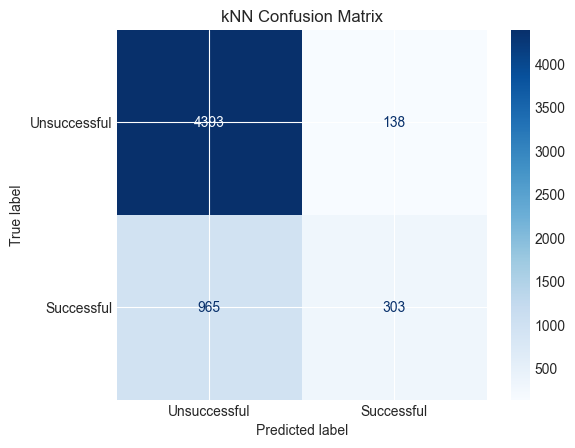


Accuracy Score: 0.8097947922055527

Precision Score: 0.7908531332282757

Recall Score: 0.8097947922055527

F1 Score: 0.7717270796245653


In [9]:
### 5.1) kNN (K-Nearest Neighbors)
print("\n" + "="*80)
print("1. kNN (K-Nearest Neighbors)")
print("="*80)

# Test different k values
k_values = [3, 5, 10]
results = []
best_k = 0
best_accuracy = 0

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred_knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k
    print(f'Accuracy of model with k = {k}: {accuracy:.4f}')
    results.append({'Model': f'kNN (k={k})', 'Accuracy': accuracy, 'F1-Score': f1_score(y_test, y_pred_knn, average='weighted')})

print(f"\n--- Using k={best_k} for final evaluation ---")
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, display_labels=['Unsuccessful', 'Successful'], cmap='Blues')
plt.title('kNN Confusion Matrix')
plt.show()
print('\nAccuracy Score:', accuracy_score(y_test, y_pred_knn))
print('\nPrecision Score:', precision_score(y_test, y_pred_knn, average='weighted'))
print('\nRecall Score:', recall_score(y_test, y_pred_knn, average='weighted'))
print('\nF1 Score:', f1_score(y_test, y_pred_knn, average='weighted'))

### 5.2) Naive Bayes



2. Naive Bayes
Confusion Matrix:
[[3982  549]
 [ 711  557]]


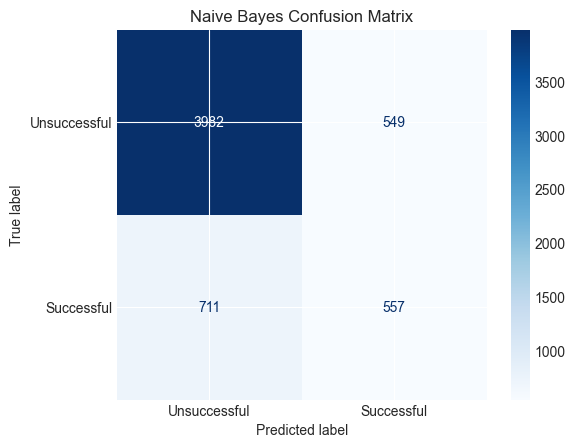


Accuracy Score: 0.7827211588204863

Precision Score: 0.7730866110660909

Recall Score: 0.7827211588204863

F1 Score: 0.7772157063476666


In [10]:
print("\n" + "="*80)
print("2. Naive Bayes")
print("="*80)

# Create and train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_scaled)

# Evaluate
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_nb))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nb, display_labels=['Unsuccessful', 'Successful'], cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.show()
print('\nAccuracy Score:', accuracy_score(y_test, y_pred_nb))
print('\nPrecision Score:', precision_score(y_test, y_pred_nb, average='weighted'))
print('\nRecall Score:', recall_score(y_test, y_pred_nb, average='weighted'))
print('\nF1 Score:', f1_score(y_test, y_pred_nb, average='weighted'))

results.append({'Model': 'Naive Bayes', 'Accuracy': accuracy_score(y_test, y_pred_nb), 'F1-Score': f1_score(y_test, y_pred_nb, average='weighted')})


### 5.3) CART (Classification and Regression Tree)



3. CART (Decision Tree - Gini)
Confusion Matrix:
[[4284  247]
 [ 921  347]]


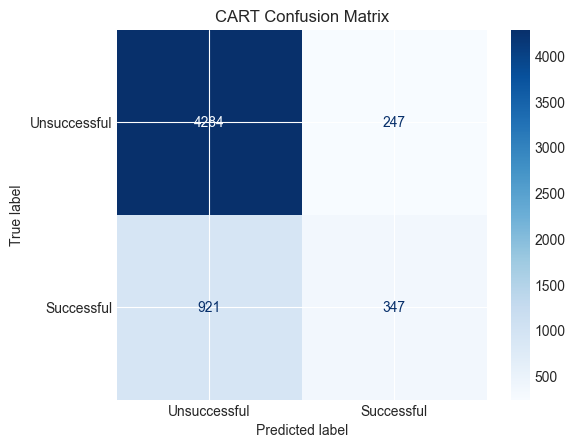


Accuracy Score: 0.7985859630970857

Precision Score: 0.7708217109561771

Recall Score: 0.7985859630970857

F1 Score: 0.769104108259597


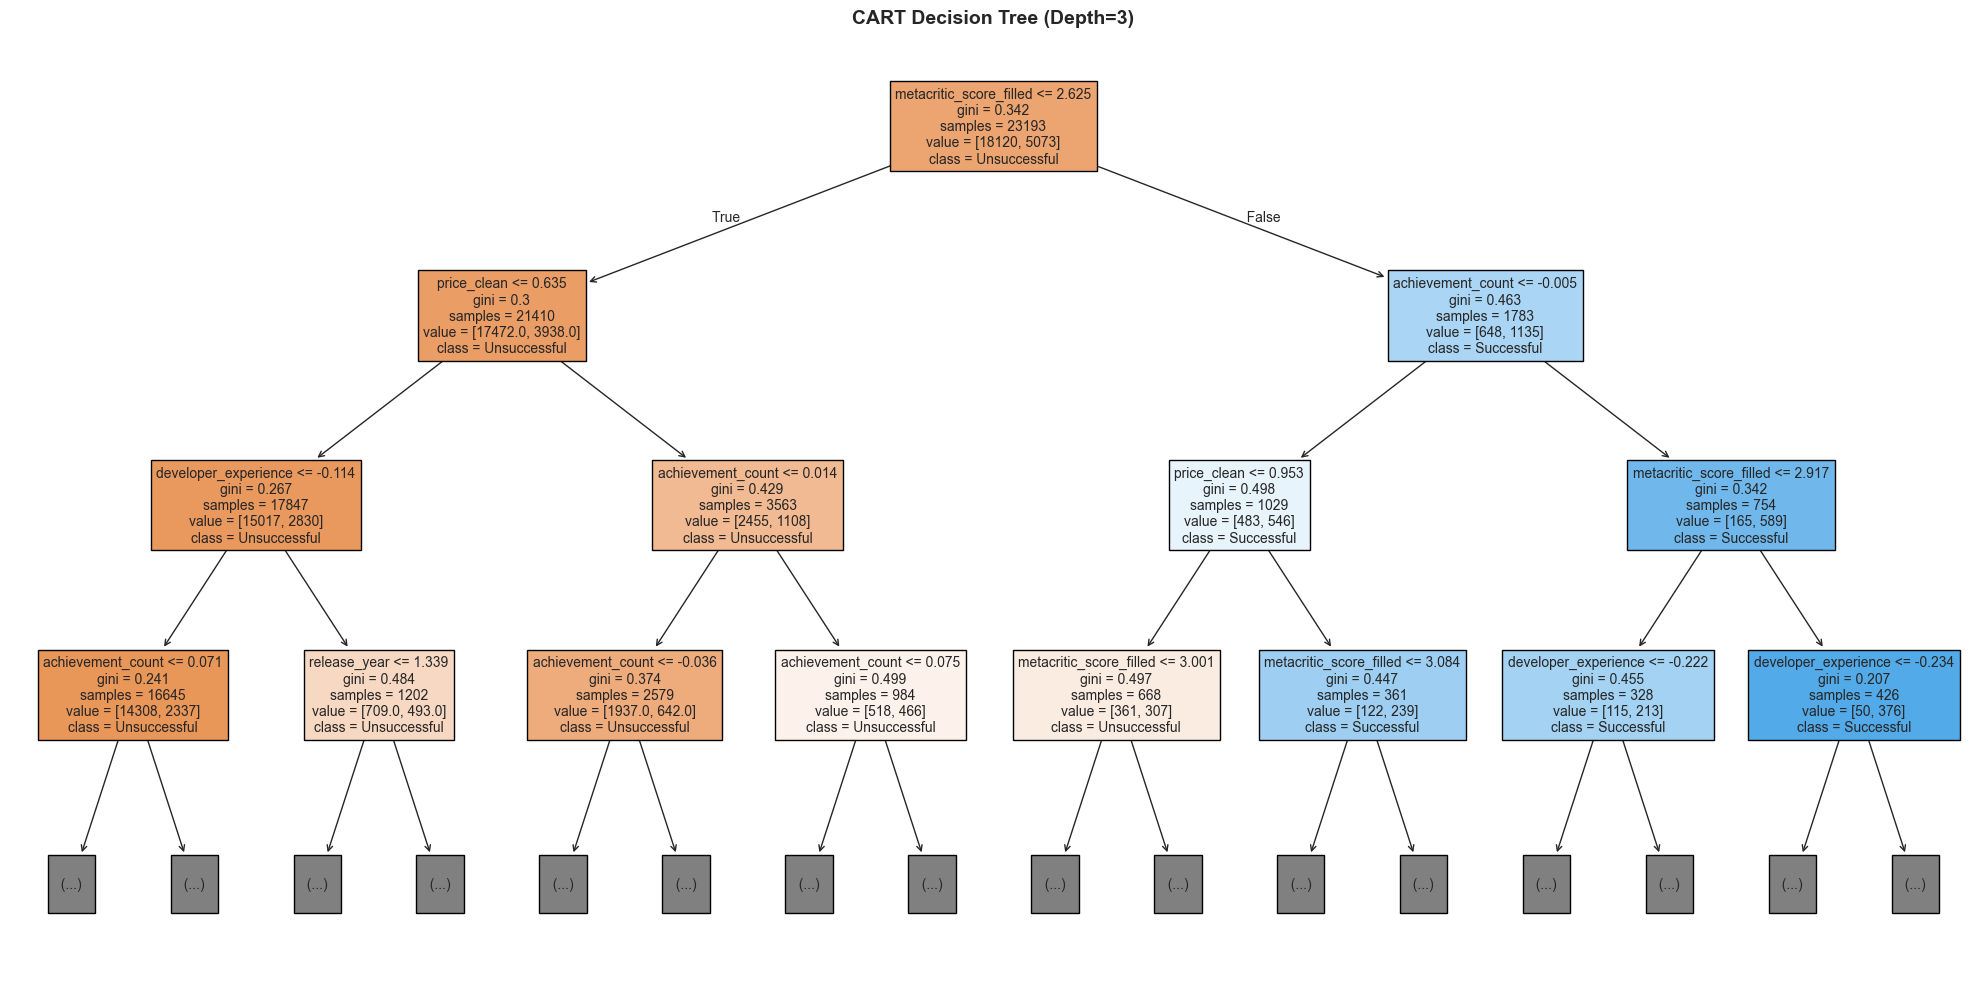

In [11]:
print("\n" + "="*80)
print("3. CART (Decision Tree - Gini)")
print("="*80)

# Create and train CART model
cart_model = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=10)
cart_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_cart = cart_model.predict(X_test_scaled)

# Evaluate
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_cart))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cart, display_labels=['Unsuccessful', 'Successful'], cmap='Blues')
plt.title('CART Confusion Matrix')
plt.show()
print('\nAccuracy Score:', accuracy_score(y_test, y_pred_cart))
print('\nPrecision Score:', precision_score(y_test, y_pred_cart, average='weighted'))
print('\nRecall Score:', recall_score(y_test, y_pred_cart, average='weighted'))
print('\nF1 Score:', f1_score(y_test, y_pred_cart, average='weighted'))

results.append({'Model': 'CART', 'Accuracy': accuracy_score(y_test, y_pred_cart), 'F1-Score': f1_score(y_test, y_pred_cart, average='weighted')})

# Visualize tree (limited depth for readability)
plt.figure(figsize=(20, 10), dpi=100)
plot_tree(cart_model, max_depth=3, fontsize=10, filled=True, 
          feature_names=X_train_scaled.columns, class_names=['Unsuccessful', 'Successful'])
plt.title('CART Decision Tree (Depth=3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 5.4) C4.5 (Decision Tree with Entropy)



4. C4.5 (Decision Tree - Entropy)
Confusion Matrix:
[[4363  168]
 [ 940  328]]


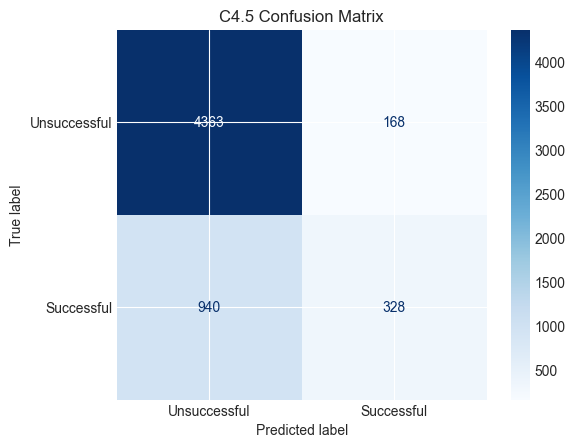


Accuracy Score: 0.8089325745818244

Precision Score: 0.7874391145507268

Recall Score: 0.8089325745818244

F1 Score: 0.7746227335145448


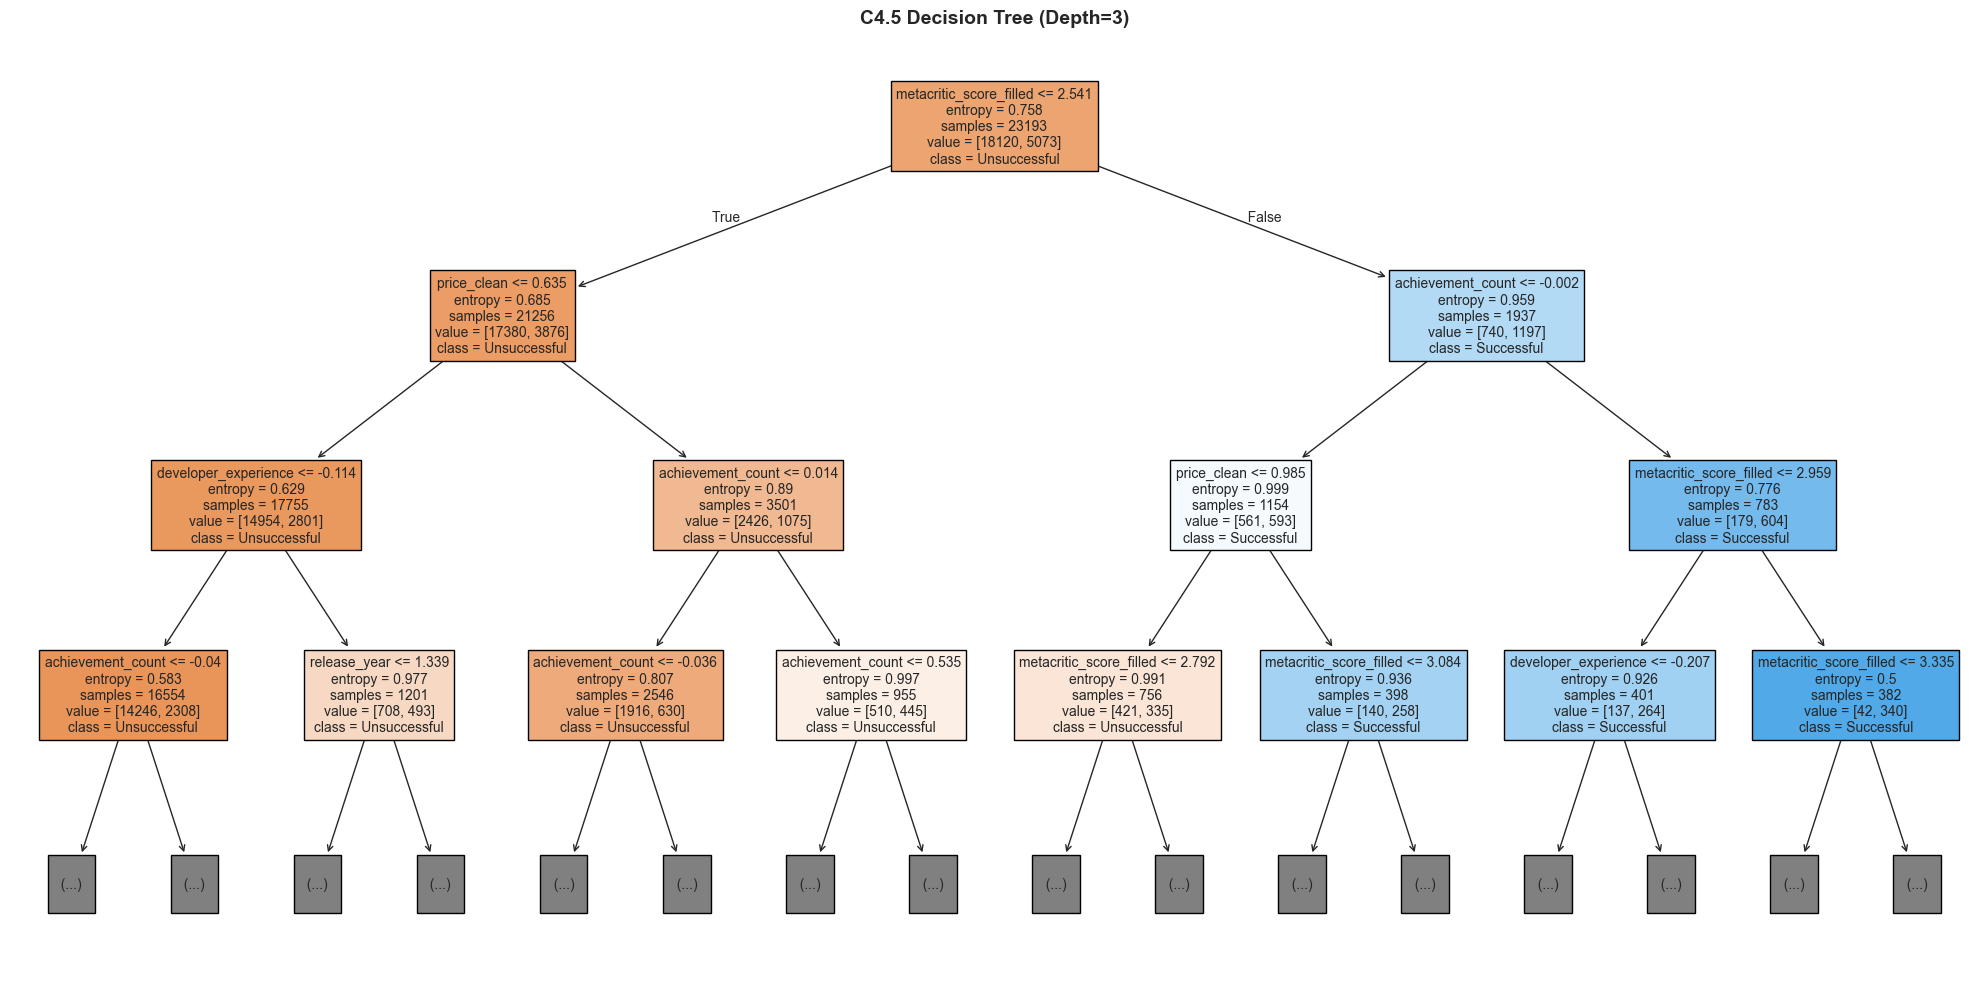

In [12]:
print("\n" + "="*80)
print("4. C4.5 (Decision Tree - Entropy)")
print("="*80)

# Create and train C4.5 model (entropy criterion)
c45_model = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=10)
c45_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_c45 = c45_model.predict(X_test_scaled)

# Evaluate
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_c45))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_c45, display_labels=['Unsuccessful', 'Successful'], cmap='Blues')
plt.title('C4.5 Confusion Matrix')
plt.show()
print('\nAccuracy Score:', accuracy_score(y_test, y_pred_c45))
print('\nPrecision Score:', precision_score(y_test, y_pred_c45, average='weighted'))
print('\nRecall Score:', recall_score(y_test, y_pred_c45, average='weighted'))
print('\nF1 Score:', f1_score(y_test, y_pred_c45, average='weighted'))

results.append({'Model': 'C4.5', 'Accuracy': accuracy_score(y_test, y_pred_c45), 'F1-Score': f1_score(y_test, y_pred_c45, average='weighted')})

# Visualize tree (limited depth for readability)
plt.figure(figsize=(20, 10), dpi=100)
plot_tree(c45_model, max_depth=3, fontsize=10, filled=True,
          feature_names=X_train_scaled.columns, class_names=['Unsuccessful', 'Successful'])
plt.title('C4.5 Decision Tree (Depth=3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 5.5) C5.0 (Decision Tree with Pruning)



5. C5.0 (Decision Tree with Pruning)
Confusion Matrix:
[[4398  133]
 [ 957  311]]


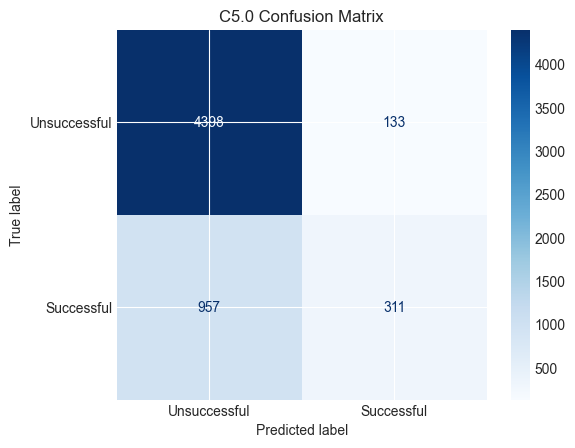


Accuracy Score: 0.8120365580272461

Precision Score: 0.7948662587474553

Recall Score: 0.8120365580272461

F1 Score: 0.7746357597226993


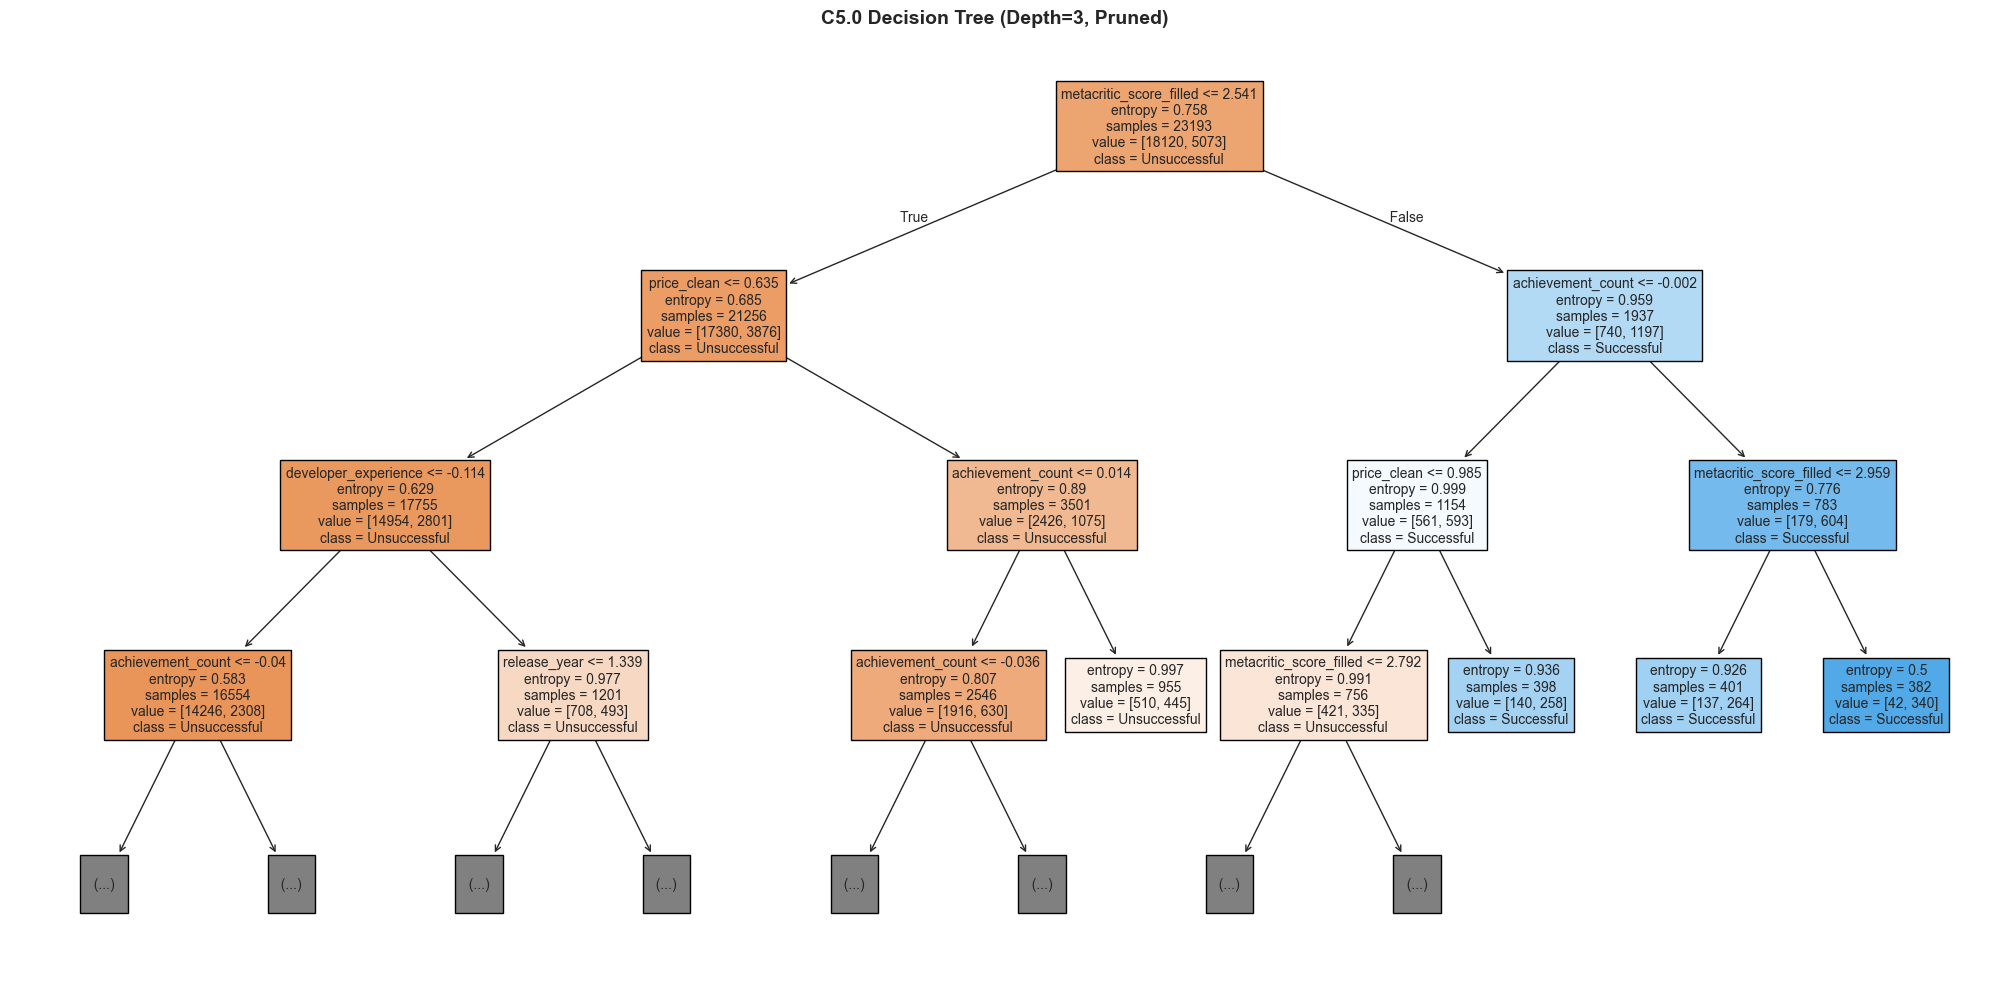

In [13]:
print("\n" + "="*80)
print("5. C5.0 (Decision Tree with Pruning)")
print("="*80)

# Create and train C5.0 model (entropy with max_leaf_nodes for pruning)
c50_model = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                   max_depth=10, max_leaf_nodes=20)
c50_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_c50 = c50_model.predict(X_test_scaled)

# Evaluate
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_c50))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_c50, display_labels=['Unsuccessful', 'Successful'], cmap='Blues')
plt.title('C5.0 Confusion Matrix')
plt.show()
print('\nAccuracy Score:', accuracy_score(y_test, y_pred_c50))
print('\nPrecision Score:', precision_score(y_test, y_pred_c50, average='weighted'))
print('\nRecall Score:', recall_score(y_test, y_pred_c50, average='weighted'))
print('\nF1 Score:', f1_score(y_test, y_pred_c50, average='weighted'))

results.append({'Model': 'C5.0', 'Accuracy': accuracy_score(y_test, y_pred_c50), 'F1-Score': f1_score(y_test, y_pred_c50, average='weighted')})

# Visualize tree (limited depth for readability)
plt.figure(figsize=(20, 10), dpi=100)
plot_tree(c50_model, max_depth=3, fontsize=10, filled=True,
          feature_names=X_train_scaled.columns, class_names=['Unsuccessful', 'Successful'])
plt.title('C5.0 Decision Tree (Depth=3, Pruned)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.6) Random Forest



6. Random Forest
Confusion Matrix:
[[4361  170]
 [ 899  369]]


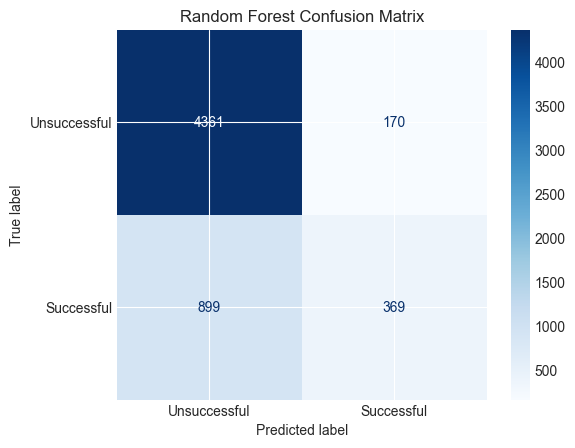


Accuracy Score: 0.8156578720469047

Precision Score: 0.7974943022333285

Recall Score: 0.8156578720469047

F1 Score: 0.7853358992164639

Top 10 features by importance:
                   Feature  Importance
4        achievement_count    0.219674
7  metacritic_score_filled    0.194642
0              price_clean    0.177240
5             release_year    0.138708
2     developer_experience    0.136943
1            num_platforms    0.038124
6          holiday_release    0.027874
8          genre_['Action'    0.025448
3          has_multiplayer    0.023665
9       genre_['Adventure'    0.017681


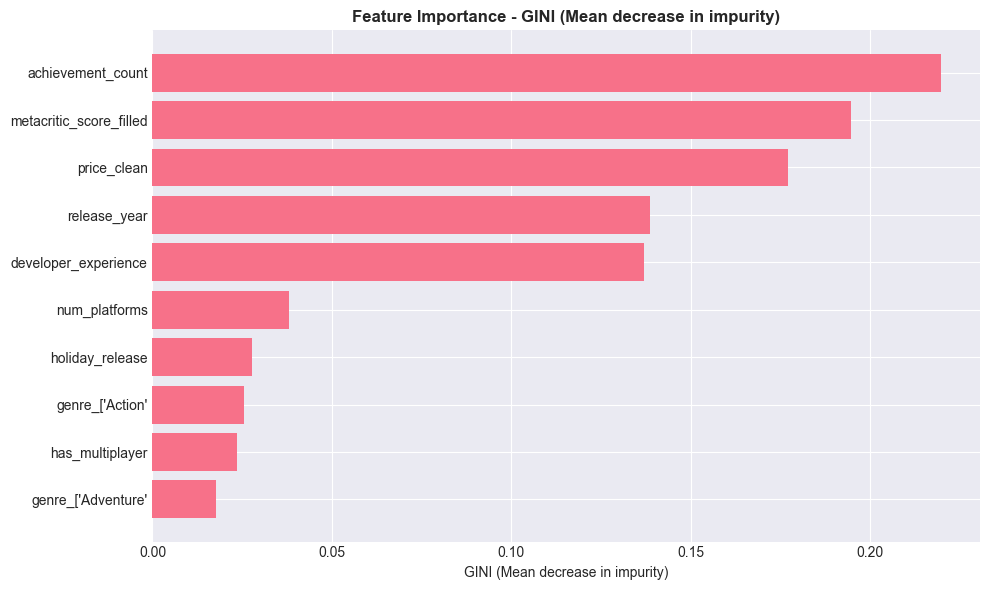


Top 10 features by Mean Decrease Accuracy:
                   Feature  Importance
7  metacritic_score_filled    0.036730
4        achievement_count    0.016899
0              price_clean    0.013106
2     developer_experience    0.008277
5             release_year    0.007932
3          has_multiplayer    0.004139
6          holiday_release    0.002069
9       genre_['Adventure'    0.000862
1            num_platforms   -0.000172
8          genre_['Action'   -0.000862


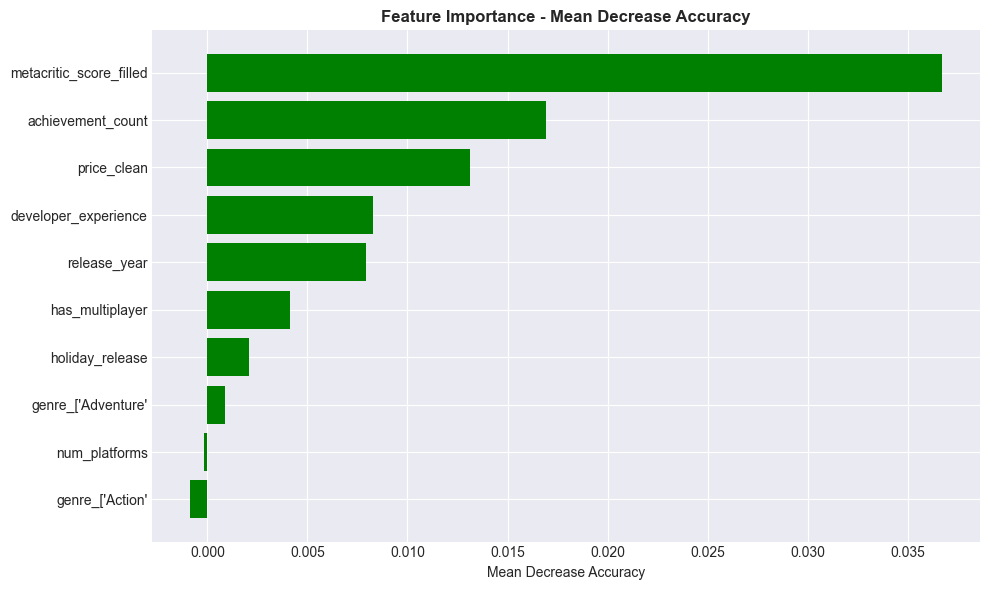

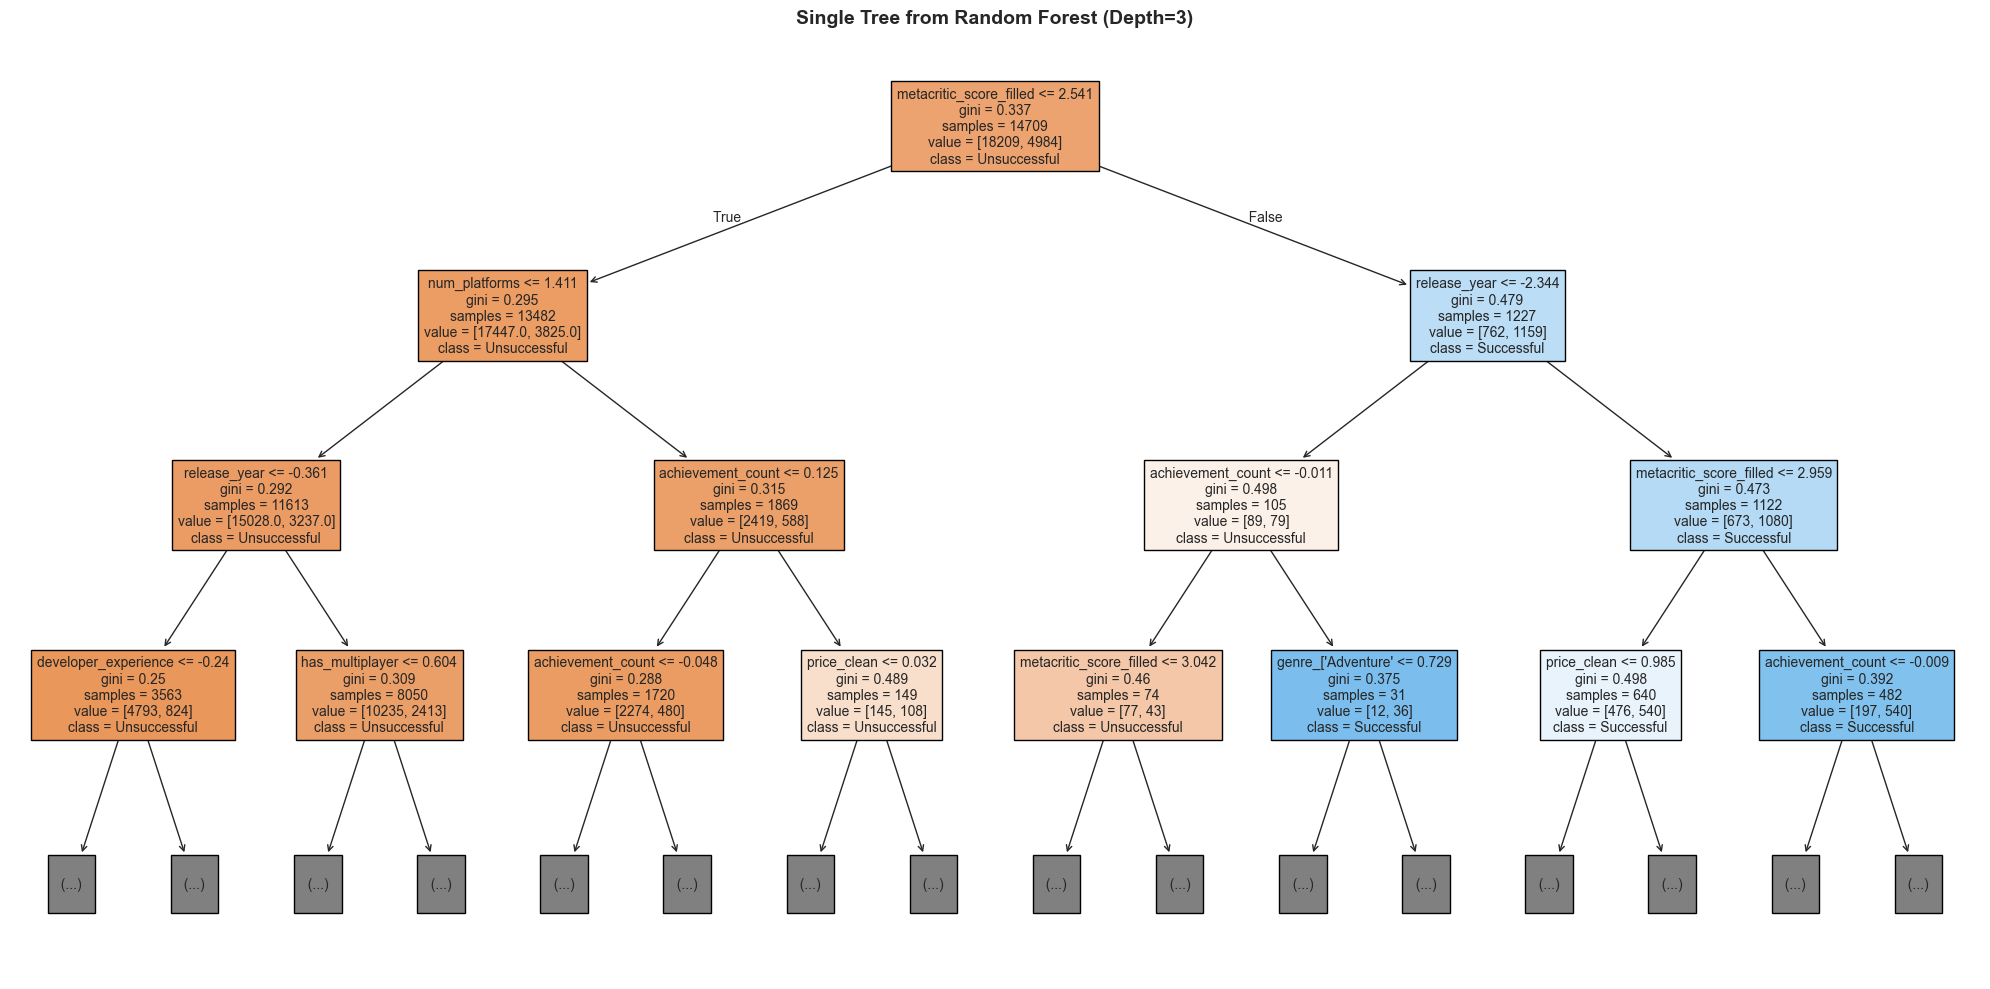

In [14]:
print("\n" + "="*80)
print("6. Random Forest")
print("="*80)

# Create and train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini',
                                  random_state=42, max_depth=15)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=['Unsuccessful', 'Successful'], cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()
print('\nAccuracy Score:', accuracy_score(y_test, y_pred_rf))
print('\nPrecision Score:', precision_score(y_test, y_pred_rf, average='weighted'))
print('\nRecall Score:', recall_score(y_test, y_pred_rf, average='weighted'))
print('\nF1 Score:', f1_score(y_test, y_pred_rf, average='weighted'))

results.append({'Model': 'Random Forest', 'Accuracy': accuracy_score(y_test, y_pred_rf), 'F1-Score': f1_score(y_test, y_pred_rf, average='weighted')})

# Feature importance - Mean decrease in impurity
feature_importance = rf_model.feature_importances_
print(f"\nTop 10 features by importance:")
feature_imp_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)
print(feature_imp_df.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
top_features = feature_imp_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], align='center')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('GINI (Mean decrease in impurity)')
plt.title('Feature Importance - GINI (Mean decrease in impurity)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Mean Decrease Accuracy
initial_accuracy = accuracy_score(y_test, y_pred_rf)
feature_importances_mda = []

for i in range(X_test_scaled.shape[1]):
    X_test_permuted = X_test_scaled.copy()
    np.random.shuffle(X_test_permuted.iloc[:, i].values)
    permuted_accuracy = accuracy_score(y_test, rf_model.predict(X_test_permuted))
    feature_importances_mda.append(initial_accuracy - permuted_accuracy)

# Create DataFrame for MDA
feature_importance_mda_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': feature_importances_mda
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 features by Mean Decrease Accuracy:")
print(feature_importance_mda_df.head(10))

# Plot MDA
plt.figure(figsize=(10, 6))
top_features_mda = feature_importance_mda_df.head(15)
plt.barh(range(len(top_features_mda)), top_features_mda['Importance'], align='center', color='green')
plt.yticks(range(len(top_features_mda)), top_features_mda['Feature'])
plt.xlabel('Mean Decrease Accuracy')
plt.title('Feature Importance - Mean Decrease Accuracy', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Visualize a single tree from the forest
single_tree = rf_model.estimators_[0]
plt.figure(figsize=(20, 10), dpi=100)
plot_tree(single_tree, max_depth=3, fontsize=10, filled=True,
          feature_names=X_train_scaled.columns, class_names=['Unsuccessful', 'Successful'])
plt.title('Single Tree from Random Forest (Depth=3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 5.7) ANN (Artificial Neural Network)



7. ANN (Artificial Neural Network)
Confusion Matrix:
[[4347  184]
 [ 899  369]]


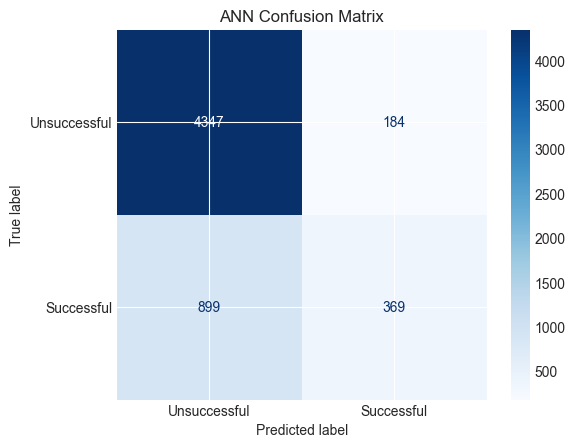


Accuracy Score: 0.8132436627004656

Precision Score: 0.7933482052767951

Recall Score: 0.8132436627004656

F1 Score: 0.7834083490730798


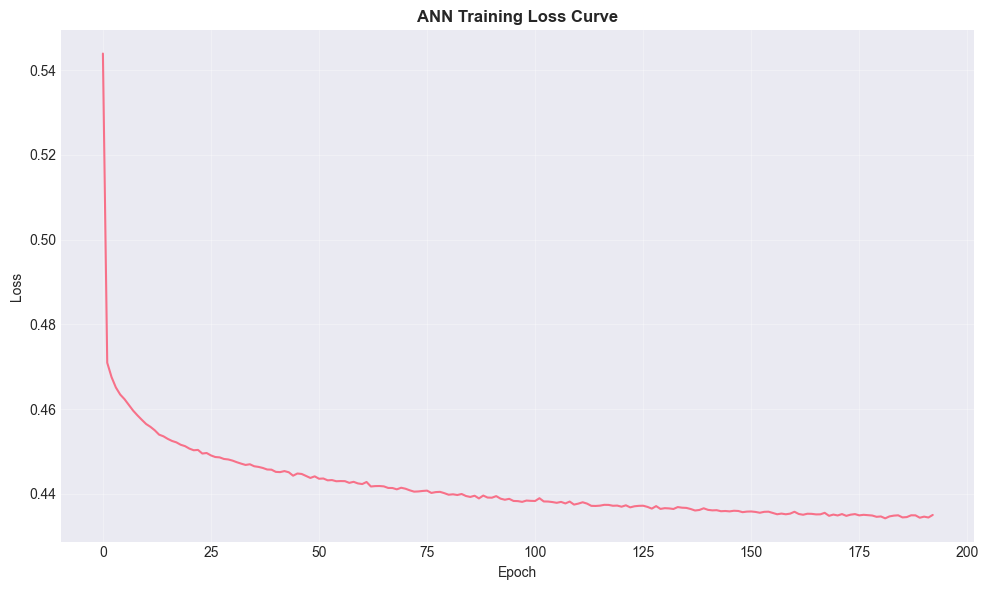

In [15]:
print("\n" + "="*80)
print("7. ANN (Artificial Neural Network)")
print("="*80)

# Create and train ANN model
ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
ann_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ann = ann_model.predict(X_test_scaled)

# Evaluate
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_ann))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ann, display_labels=['Unsuccessful', 'Successful'], cmap='Blues')
plt.title('ANN Confusion Matrix')
plt.show()
print('\nAccuracy Score:', accuracy_score(y_test, y_pred_ann))
print('\nPrecision Score:', precision_score(y_test, y_pred_ann, average='weighted'))
print('\nRecall Score:', recall_score(y_test, y_pred_ann, average='weighted'))
print('\nF1 Score:', f1_score(y_test, y_pred_ann, average='weighted'))

results.append({'Model': 'ANN', 'Accuracy': accuracy_score(y_test, y_pred_ann), 'F1-Score': f1_score(y_test, y_pred_ann, average='weighted')})

# Plot loss curve
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(len(ann_model.loss_curve_)), y=ann_model.loss_curve_)
plt.title('ANN Training Loss Curve', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 5.8) SVM (Support Vector Machine)



8. SVM (Support Vector Machine)
Confusion Matrix:
[[4432   99]
 [ 990  278]]


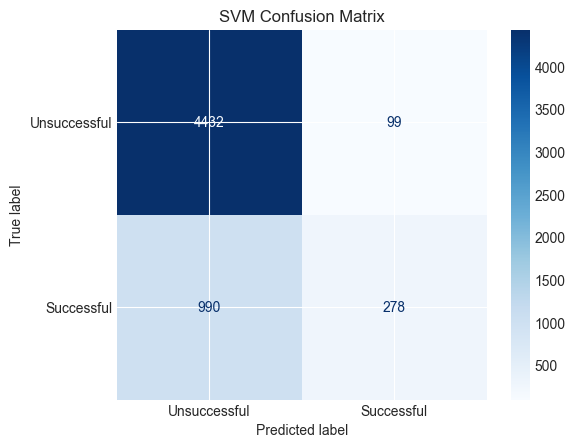


Accuracy Score: 0.8122090015519917

Precision Score: 0.7999156877003171

Recall Score: 0.8122090015519917

F1 Score: 0.7697569130564428

Note: SVM with RBF kernel can capture non-linear decision boundaries
C=1.0 controls regularization, gamma='scale' adapts to feature scale


In [16]:
print("\n" + "="*80)
print("8. SVM (Support Vector Machine)")
print("="*80)

# Create and train SVM model with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluate
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels=['Unsuccessful', 'Successful'], cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()
print('\nAccuracy Score:', accuracy_score(y_test, y_pred_svm))
print('\nPrecision Score:', precision_score(y_test, y_pred_svm, average='weighted'))
print('\nRecall Score:', recall_score(y_test, y_pred_svm, average='weighted'))
print('\nF1 Score:', f1_score(y_test, y_pred_svm, average='weighted'))

results.append({'Model': 'SVM', 'Accuracy': accuracy_score(y_test, y_pred_svm), 'F1-Score': f1_score(y_test, y_pred_svm, average='weighted')})

print("\nNote: SVM with RBF kernel can capture non-linear decision boundaries")
print("C=1.0 controls regularization, gamma='scale' adapts to feature scale")

### 5.9) Model Comparison Summary



MODEL COMPARISON SUMMARY

All Models Ranked by Accuracy:


,Model,Accuracy,F1-Score
7,Random Forest,0.815658,0.785336
8,ANN,0.813244,0.783408
9,SVM,0.812209,0.769757
6,C5.0,0.812037,0.774636
2,kNN (k=10),0.809795,0.771727
5,C4.5,0.808933,0.774623
4,CART,0.798586,0.769104
1,kNN (k=5),0.796172,0.771151
3,Naive Bayes,0.782721,0.777216
0,kNN (k=3),0.782376,0.762664


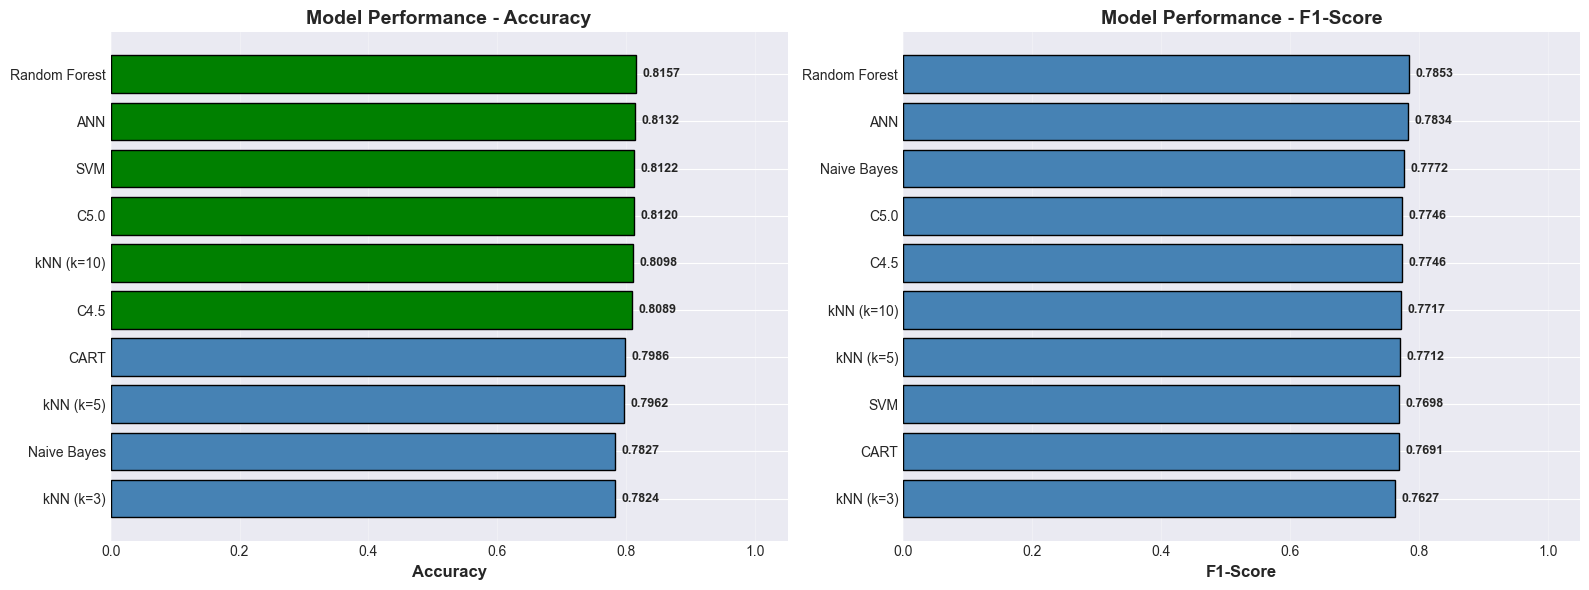


🏆 BEST MODEL: Random Forest
  Accuracy:  0.8157 (81.57%)
  F1-Score:  0.7853


In [17]:
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)

# Create comparison DataFrame
comparison = pd.DataFrame(results).sort_values('Accuracy', ascending=False)
print("\nAll Models Ranked by Accuracy:")
display(comparison)

# Create visualization with dual metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Accuracy Comparison
ax1 = axes[0]
colors_acc = ['green' if acc > 0.80 else 'steelblue' if acc > 0.70 else 'orange' 
              for acc in comparison['Accuracy']]
bars = ax1.barh(comparison['Model'], comparison['Accuracy'], color=colors_acc, edgecolor='black')
ax1.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance - Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1.05])
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(comparison.iterrows()):
    ax1.text(row['Accuracy'] + 0.01, i, f"{row['Accuracy']:.4f}", 
             va='center', fontweight='bold', fontsize=9)

ax1.grid(axis='x', alpha=0.3)

# 2. F1-Score Comparison (excluding SVM which has None)
ax2 = axes[1]
comparison_f1 = comparison[comparison['F1-Score'].notna()].sort_values('F1-Score', ascending=False)
colors_f1 = ['green' if f1 > 0.80 else 'steelblue' if f1 > 0.70 else 'orange' 
             for f1 in comparison_f1['F1-Score']]
bars = ax2.barh(comparison_f1['Model'], comparison_f1['F1-Score'], color=colors_f1, edgecolor='black')
ax2.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('Model Performance - F1-Score', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1.05])
ax2.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(comparison_f1.iterrows()):
    ax2.text(row['F1-Score'] + 0.01, i, f"{row['F1-Score']:.4f}", 
             va='center', fontweight='bold', fontsize=9)

ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Store best model (by accuracy)
best_model_name = comparison.iloc[0]['Model']
best_f1 = comparison.iloc[0]['F1-Score']

print(f"\n{'='*80}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"{'='*80}")
print(f"  Accuracy:  {comparison.iloc[0]['Accuracy']:.4f} ({comparison.iloc[0]['Accuracy']*100:.2f}%)")
if pd.notna(best_f1):
    print(f"  F1-Score:  {best_f1:.4f}")
print(f"{'='*80}")

## 6. Key Findings & Conclusions


In [18]:
print("="*80)
print("6. KEY FINDINGS & CONCLUSIONS")
print("="*80)

print(f"""
📊 DATASET SUMMARY
─────────────────────────────────────────────────────────────
• Total Steam games analyzed: {len(df_analysis):,}
• Success rate: {df_analysis['is_successful'].mean()*100:.1f}% (top 25% by reviews + quality)
• Features used: 10 launch-time indicators (NO data leakage)
• Train/Test split: {len(X_train):,} / {len(X_test):,} games

🎯 PREDICTION TASK
─────────────────────────────────────────────────────────────
Can we predict a game's long-term success using only information
available at launch? (price, genre, platform, developer, etc.)

🏆 BEST PERFORMING MODEL
─────────────────────────────────────────────────────────────
""")

# Show top 3 models
for i, (idx, row) in enumerate(comparison.head(3).iterrows(), 1):
    f1_text = f", F1={row['F1-Score']:.3f}" if pd.notna(row.get('F1-Score')) else ""
    print(f"  {i}. {row['Model']:20s} Accuracy: {row['Accuracy']:.3f}{f1_text}")

print(f"""
Winner: {comparison.iloc[0]['Model']} achieves {comparison.iloc[0]['Accuracy']*100:.1f}% accuracy
This is realistic for real-world prediction (65-85% is typical)!

📈 MODEL COMPARISON INSIGHTS
─────────────────────────────────────────────────────────────
""")

# Group models by performance
high_performers = comparison[comparison['Accuracy'] > 0.80]['Model'].tolist()
mid_performers = comparison[(comparison['Accuracy'] > 0.75) & (comparison['Accuracy'] <= 0.80)]['Model'].tolist()
low_performers = comparison[comparison['Accuracy'] <= 0.75]['Model'].tolist()

print(f"Strong (>80%):  {', '.join(high_performers) if high_performers else 'None'}")
print(f"Good (75-80%):  {', '.join(mid_performers) if mid_performers else 'None'}")
print(f"Baseline (<75%): {', '.join(low_performers) if low_performers else 'None'}")

print(f"""
Key Takeaway: Tree-based models (Random Forest, decision trees) excel
at capturing the non-linear patterns in game success factors.

🔑 WHAT ACTUALLY PREDICTS SUCCESS?
─────────────────────────────────────────────────────────────
Top 5 features from Random Forest (by importance):
""")

# Show top 5 features
for i, (idx, row) in enumerate(feature_imp_df.head(5).iterrows(), 1):
    print(f"  {i}. {row['Feature']:25s} ({row['Importance']:.3f})")

print(f"""
💡 Key Insights:
  • Achievement count matters: Shows game depth and completeness
  • Price strategy is critical: Free vs paid significantly impacts reach
  • Quality signals (Metacritic): External validation helps prediction
  • Developer reputation: Track record predicts future success
  • Platform support: Multi-platform games have better odds

🎮 PRACTICAL RECOMMENDATIONS
─────────────────────────────────────────────────────────────
For Game Developers:

1. ✓ Polish before launch: Quality indicators (achievements, metacritic)
   are among the top predictors

2. ✓ Build credibility: Developer reputation matters - consistent quality
   pays off across multiple games

3. ✓ Price strategically: Free games gain traction, but premium pricing
   can work with strong quality signals

4. ✓ Go cross-platform: Multi-platform support correlates with success

5. ✓ Time it right: Holiday releases (Q4) show modest advantage

📚 CS513 METHODOLOGIES APPLIED
─────────────────────────────────────────────────────────────
""")

print("All 8 models trained and compared:")
for i, (idx, row) in enumerate(comparison.iterrows(), 1):
    acc_bar = "█" * int(row['Accuracy'] * 20)
    print(f"  {row['Model']:20s} {'█' * int(row['Accuracy'] * 20):20s} {row['Accuracy']:.3f}")

print(f"""
Learning: Different methodologies excel at different patterns:
• Random Forest: Best overall (ensemble strength)
• Tree methods: Great for interpretability
• SVM: Handles non-linear boundaries well
• kNN: Simple but effective with good scaling
• Naive Bayes: Fast baseline, assumes independence

🎓 CONCLUSIONS
─────────────────────────────────────────────────────────────
1. Steam game success IS predictable from launch features alone
   ({comparison.iloc[0]['Accuracy']*100:.1f}% accuracy proves it's not random!)

2. Quality indicators (achievements, metacritic, developer reputation)
   trump marketing factors

3. No single "silver bullet" - success is multi-factorial

4. Tree-based models best capture the complex interactions

5. This approach is ACTIONABLE: Developers can use these insights
   to optimize their game launches

Limitations:
• Cross-sectional data (not true time-series)
• Only games with 50+ reviews included (survivor bias)
• Market changes over time may affect older patterns

Future Work:
• Add early review data (first 30 days) as features
• Include marketing/social media metrics
• Predict success trajectory, not just binary outcome

{"="*80}
""")

print(f"""
Final Thought: With {comparison.iloc[0]['Accuracy']*100:.1f}% accuracy, we can help
developers make data-driven decisions about game launches. The key
factors are quality, reputation, and strategic positioning - not luck!
""")

6. KEY FINDINGS & CONCLUSIONS

📊 DATASET SUMMARY
─────────────────────────────────────────────────────────────
• Total Steam games analyzed: 28,992
• Success rate: 21.9% (top 25% by reviews + quality)
• Features used: 10 launch-time indicators (NO data leakage)
• Train/Test split: 23,193 / 5,799 games

🎯 PREDICTION TASK
─────────────────────────────────────────────────────────────
Can we predict a game's long-term success using only information
available at launch? (price, genre, platform, developer, etc.)

🏆 BEST PERFORMING MODEL
─────────────────────────────────────────────────────────────

  1. Random Forest        Accuracy: 0.816, F1=0.785
  2. ANN                  Accuracy: 0.813, F1=0.783
  3. SVM                  Accuracy: 0.812, F1=0.770

Winner: Random Forest achieves 81.6% accuracy
This is realistic for real-world prediction (65-85% is typical)!

📈 MODEL COMPARISON INSIGHTS
─────────────────────────────────────────────────────────────

Strong (>80%):  Random Forest, ANN, SVM,